In [1]:
import requests
import json
import pandas
import zipfile
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
from tqdm.notebook import tqdm
import os
import shutil
import random

## Построение графика изменения стоимости пая фонда Тинькофф iMOEX

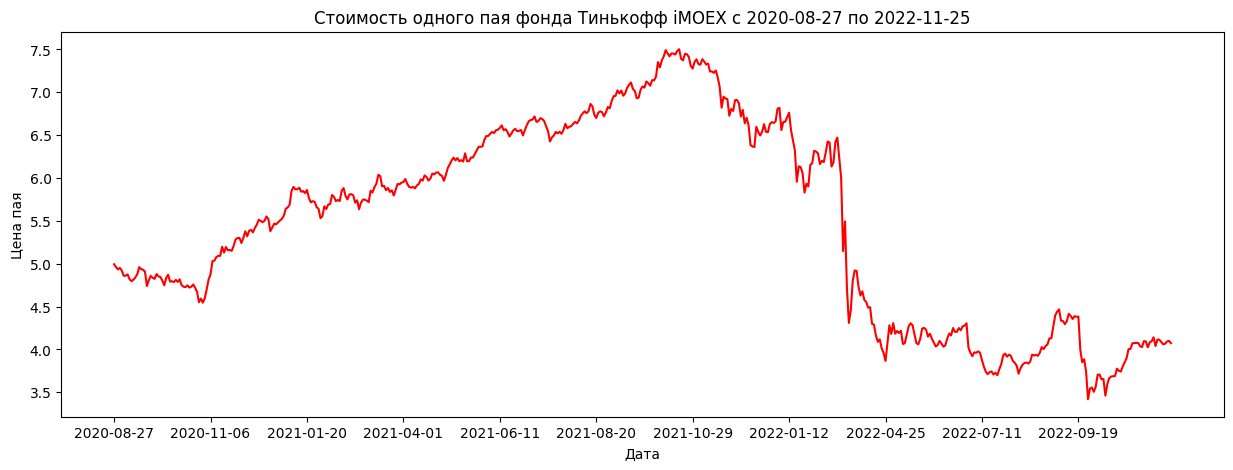

In [3]:
tmos = pd.read_csv('tmos_history.csv')
tmos['Date'] = tmos['Date'].apply(lambda x: datetime.datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d'))
tmos_dates = tmos['Date'].values.tolist()
tmos_dates.reverse()

tmos_prices = tmos['Price'].values.tolist()
tmos_prices.reverse()

plt.figure(0, figsize=(15,5))
plt.plot(tmos_dates, tmos_prices, color='red')
plt.xlabel('Дата')
plt.ylabel('Цена пая')
plt.xticks([tmos_dates[x] for x in range(0, len(tmos_dates), 50)])
plt.title('Стоимость одного пая фонда Тинькофф iMOEX с 2020-08-27 по 2022-11-25')
plt.show()

## Получение исторический данных по всем тикерам фонда iMOEX

In [ ]:
access_token = 't.z7ykQhVounaZO-1oq4PZUhERNigGHDZ0BwP7Ldv0F00npdU6_VtBMYlDlSkQjnhQ-4dPGTfV35m2aJ1QfDd_Uw'

In [ ]:
figi_dict = {'LKOH': 'BBG004731032',
             'SBER': 'BBG004730N88',
             'GAZP': 'BBG004730RP0',
             'GMKN': 'BBG004731489',
             'NVTK': 'BBG00475KKY8',
             'YNDX': 'BBG006L8G4H1',
             'ROSN': 'BBG004731354',
             'MGNT': 'BBG004RVFCY3',
             'TCS': 'BBG005CW7C28',
             'TATN': 'BBG004RVFFC0',
             'PHOR': 'BBG004S689R0',
             'PLZL': 'BBG000R607Y3',
             'SNGS': 'BBG0047315D0',
             'MTSS': 'BBG004S681W1',
             'FIVE': 'BBG00JXPFBN0',
             'CHMF': 'BBG00475K6C3',
             'ALRS': 'BBG004S68B31',
             'NLMK': 'BBG004S681B4',
             'SNGSP': 'BBG004S681M2',
             'MOEX': 'BBG004730JJ5',
             'SBERP': 'BBG0047315Y7',
             'POLY': 'BBG004PYF2N3',
             'OZON': 'BBG00Y91R9T3',
             'IRAO': 'BBG004S68473',
             'RUAL': 'BBG008F2T3T2',
             'PIKK': 'BBG004S68BH6',
             'HYDR': 'BBG00475K2X9',
             'MAGN': 'BBG004S68507',
             'VTBR': 'BBG004730ZJ9', 
             'VKCO': 'BBG00VSZZRN0',
             'TATNP': 'BBG004S68829',
             'RTKM': 'BBG004S682Z6',
             'CBOM': 'BBG009GSYN76',
             'TRNFP': 'BBG00475KHX6',
             'FIXP': 'BBG00ZDPWZS9', 
             'AFKS': 'BBG004S68614',
             'ENPG': 'BBG000RMWQD4',
             'DSKY': 'BBG000BN56Q9',
             'GLTR': 'BBG00Y04Q9P1',
             'AFLT': 'BBG004S683W7'}

In [ ]:
def download_and_merge_figis_stats(access_token: str, figi_dict: dict) -> pd.DataFrame():
    headers = {'Authorization': 'Bearer ' + access_token}

    all_figis_stats = []

    for figi in tqdm(figi_dict.keys()):
        if os.path.exists(f'{figi}'):
            shutil.rmtree(f'{figi}')

        os.makedirs(f'{figi}')

        all_years_stats = []

        for year in [2020, 2021, 2022]:
            get_history = requests.get(f'https://invest-public-api.tinkoff.ru/history-data?figi={figi_dict[figi]}&year={year}', headers=headers)
            
            if get_history.status_code == 429:
                print(f'Flood-control. Waits 1 minute. Current status code: {get_history.status_code}')
                time.sleep(61)
                get_history = requests.get(f'https://invest-public-api.tinkoff.ru/history-data?figi={figi_dict[figi]}&year={year}', headers=headers)
            
            if get_history.status_code == 404:
                print(f'No data for {figi} for {year}')
                continue

            with zipfile.ZipFile(io.BytesIO(get_history.content), mode="r") as archive:
                archive.extractall(f'{figi}/{year}')

            figi_files = os.listdir(f'{figi}/{year}')

            for figi_file in figi_files:
                figi_csv = pd.read_csv(f'{figi}/{year}/{figi_file}', sep=';', header=None)
                figi_csv.drop(columns=[7], inplace=True)

                figi_csv.columns = ['figi', 'utc', 'open', 'close', 'high', 'low', 'volume']

                day_slice = figi_csv.groupby('figi').agg({'high': max,
                                                      'low': min, 
                                                      'volume': sum}).reset_index()

                day_slice['day'] = figi_csv.iloc[0, 1][:10]
                day_slice['open'] = figi_csv.iloc[0, 2]
                day_slice['close'] = figi_csv.iloc[-1, 3]
                day_slice.drop(columns=['figi'], inplace=True)
                day_slice = day_slice[['day', 'open', 'close', 'high', 'low', 'volume']]
                day_slice.set_index('day', inplace=True)
                day_slice.columns = [figi+'_'+column for column in day_slice.columns]

                all_years_stats.append(day_slice)
                
        if not all_years_stats:
            print(f'There are no data for {figi}')
            continue
        
        all_years_stats_merged = pd.concat(all_years_stats, axis=0).reset_index()
        all_years_stats_merged['day'] = all_years_stats_merged['day'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
        all_years_stats_merged.sort_values(by='day', inplace=True)
        all_years_stats_merged = all_years_stats_merged.set_index('day')
        all_figis_stats.append(all_years_stats_merged)

    final_table = pd.concat(all_figis_stats, axis=1)
    return final_table


In [ ]:
table = download_and_merge_figis_stats(access_token, figi_dict)
table.to_csv('table.csv')

In [4]:
remain_files = ['tcsg.csv', 'vkco.csv', 'fixp.csv', 'gltr.csv']
table = pd.read_csv('table.csv')
table['day'] = table['day'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
table = table[(table['day'] >= '2020-08-27') & (table['day'] < '2022-11-26')]
table.set_index('day', inplace=True)

box = [table]

for file in remain_files:
    stock = pd.read_csv(file)
    ticker = file[:4].upper()
    stock.drop(columns=['<TICKER>', '<PER>', '<TIME>'], inplace=True)
    stock.columns = ['day', ticker+'_'+'open', ticker+'_'+'close', ticker+'_'+'high', ticker+'_'+'low', ticker+'_'+'volume']
    stock['day'] = stock['day'].astype(str).apply(lambda x: datetime.datetime.strptime(datetime.datetime.strptime(x, '%Y%m%d').strftime('%Y-%m-%d'), '%Y-%m-%d'))
    stock.sort_values(by='day', inplace=True)
    stock.set_index('day', inplace=True)
    box.append(stock)

nn_data = pd.concat(box, axis=1).fillna(0.0)

tmos = pd.read_csv('tmos_history.csv')
tmos['Date'] = tmos['Date'].apply(lambda x: datetime.datetime.strptime(datetime.datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d'), '%Y-%m-%d'))
tmos.drop(columns=['Change %'], inplace=True)

tmos = tmos[['Date', 'Open', 'Price', 'High', 'Low', 'Vol.']]
tmos.columns = ['date', 'open', 'close', 'high', 'low', 'volume']

tmos['volume'] = tmos['volume'].apply(lambda x: int(float(x[:4]) * 1_000_000))
tmos.set_index('date', inplace=True)

dataset = pd.concat([nn_data, tmos], axis=1).reset_index().fillna(0.0)

new_types = {x: int for x in dataset.columns if 'volume' in x}
dataset = dataset.astype(new_types)
dataset.to_csv('dataset.csv')
dataset.rename(columns={'index': 'date'}, inplace=True)

## Предобработка данных для дальнейшего исследования

In [5]:
dataset = dataset[dataset['close'] != 0.000].reset_index(drop=True)

close_values = np.array(dataset['close'].values)
fond_values = dataset[['open', 'high', 'low', 'volume']]
dates = dataset['date'].values
dataset.drop(columns=['close', 'open', 'high', 'low', 'volume'], inplace=True)
dataset['date'] = dataset['date'].astype(str)
dataset.head(3)

,date,LKOH_open,LKOH_close,LKOH_high,LKOH_low,LKOH_volume,SBER_open,SBER_close,SBER_high,SBER_low,...,FIXP_open,FIXP_close,FIXP_high,FIXP_low,FIXP_volume,GLTR_open,GLTR_close,GLTR_high,GLTR_low,GLTR_volume
0,2020-08-27,5286.0,5174.0,5292.5,5154.0,1030110,227.80,226.23,229.98,225.60,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,2020-08-28,5170.0,5082.0,5178.5,5056.5,776902,227.00,226.30,228.10,225.19,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,2020-08-31,5096.0,4991.0,5128.5,4960.0,1416679,227.02,226.10,229.71,225.00,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


## Добавление данных по курсу валют в текущий датасет

In [6]:
pd.options.mode.chained_assignment = None

In [7]:
usd_exchange_rates = pd.read_csv('usd_exchange_rates.csv')
eur_exchange_rates = pd.read_csv('eur_exchange_rates.csv')

usd_exchange_rates['curs'] = usd_exchange_rates['curs'].apply(lambda x: round(float(x.replace(',', '.')),2 ))
usd_exchange_rates['data'] = usd_exchange_rates['data'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%Y-%m-%d'))
usd_exchange_rates.drop(columns=['cdx'], inplace=True)
usd_exchange_rates.columns = ['date', 'usd_exchange_rate']
usd_exchange_rates.set_index('date', inplace=True)

eur_exchange_rates['curs'] = eur_exchange_rates['curs'].apply(lambda x: round(float(x.replace(',', '.')), 2))
eur_exchange_rates['data'] = eur_exchange_rates['data'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%Y-%m-%d'))
eur_exchange_rates.drop(columns=['cdx'], inplace=True)
eur_exchange_rates.columns = ['date', 'eur_exchange_rate']
eur_exchange_rates.set_index('date', inplace=True)


merged_exchange_rates = pd.concat([usd_exchange_rates, eur_exchange_rates], axis=1)
merged_exchange_rates = merged_exchange_rates.reset_index()

dataset = pd.merge(dataset, merged_exchange_rates, on='date', how='left')

# Заполняем пустые значения курса валют по среднему предыдущего и последующего значения
null_usd_indexes = dataset.loc[dataset['usd_exchange_rate'].isna(), ['date', 'usd_exchange_rate']].index
for null_index in null_usd_indexes:
    avg_rate = round((dataset['usd_exchange_rate'].loc[null_index-1] + dataset['usd_exchange_rate'].loc[null_index+1]) / 2, 2)
    dataset['usd_exchange_rate'].loc[null_index] = avg_rate
    
null_eur_indexes = dataset.loc[dataset['eur_exchange_rate'].isna(), ['date', 'eur_exchange_rate']].index
for null_index in null_eur_indexes:
    avg_rate = round((dataset['eur_exchange_rate'].loc[null_index-1] + dataset['eur_exchange_rate'].loc[null_index+1]) / 2, 2)
    dataset['eur_exchange_rate'].loc[null_index] = avg_rate

exchange_rates_df = dataset[['date', 'usd_exchange_rate', 'eur_exchange_rate']]
dataset.drop(columns=['date', 'usd_exchange_rate', 'eur_exchange_rate'], inplace=True)
dataset.head(3)

,LKOH_open,LKOH_close,LKOH_high,LKOH_low,LKOH_volume,SBER_open,SBER_close,SBER_high,SBER_low,SBER_volume,...,FIXP_open,FIXP_close,FIXP_high,FIXP_low,FIXP_volume,GLTR_open,GLTR_close,GLTR_high,GLTR_low,GLTR_volume
0,5286.0,5174.0,5292.5,5154.0,1030110,227.80,226.23,229.98,225.60,5100554,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,5170.0,5082.0,5178.5,5056.5,776902,227.00,226.30,228.10,225.19,4070058,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,5096.0,4991.0,5128.5,4960.0,1416679,227.02,226.10,229.71,225.00,6194464,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


In [8]:
# Replacing NaN euro values
for date in ['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-08', '2021-01-11']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'eur_exchange_rate'] = round(random.uniform(90.75, 90.81), 2)

for date in ['2021-02-22', '2021-02-24']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'eur_exchange_rate'] = round(random.uniform(89.60, 89.70), 2)
    
for date in ['2021-05-10', '2021-05-11']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'eur_exchange_rate'] = round(random.uniform(89.50, 90.00), 2)
    
for date in ['2021-06-14', '2021-06-15']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'eur_exchange_rate'] = round(random.uniform(87.21, 87.32), 2)
    
for date in ['2021-11-05', '2021-11-08']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'eur_exchange_rate'] = round(random.uniform(82.50, 82.80), 2)
    
for date in ['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-10']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'eur_exchange_rate'] = round(random.uniform(84.05, 85.13), 2)
    
# Replacing NaN usd values
for date in ['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-08', '2021-01-11']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'usd_exchange_rate'] = round(random.uniform(73.87, 74.51), 2)

for date in ['2021-02-22', '2021-02-24']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'usd_exchange_rate'] = round(random.uniform(73.70, 73.90), 2)
    
for date in ['2021-05-10', '2021-05-11']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'usd_exchange_rate'] = round(random.uniform(74.13, 74.15), 2)
    
for date in ['2021-06-14', '2021-06-15']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'usd_exchange_rate'] = round(random.uniform(71.67, 71.83), 2)
    
for date in ['2021-11-05', '2021-11-08']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'usd_exchange_rate'] = round(random.uniform(71.39, 71.50), 2)
    
for date in ['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-10']:
    exchange_rates_df.loc[exchange_rates_df['date']==date, 'usd_exchange_rate'] = round(random.uniform(74.29, 75.13), 2)
    
exchange_rates_df = exchange_rates_df[['usd_exchange_rate', 'eur_exchange_rate']]

## Корреляционный анализ open, close, high, low и volume признаков по каждому тикеру с ценой закрытия фонда iMOEX

In [9]:
def calculate_correlation(val1: np.array, val2: np.array):
    return round(np.corrcoef(val1, val2)[0,1], 3)

correlations_box = []

for column in dataset.columns:
    val1 = np.array(dataset[column].values)
    correlation_dict = {}
    correlation_dict['value_1'] = column
    correlation_dict['value_2'] = 'iMOEX_close'
    correlation_dict['correlation_value'] = calculate_correlation(val1, close_values)
    correlations_box.append(correlation_dict)
    
corr_df = pd.DataFrame(correlations_box)
corr_df.head(3)

,value_1,value_2,correlation_value
0,LKOH_open,iMOEX_close,0.958
1,LKOH_close,iMOEX_close,0.962
2,LKOH_high,iMOEX_close,0.956


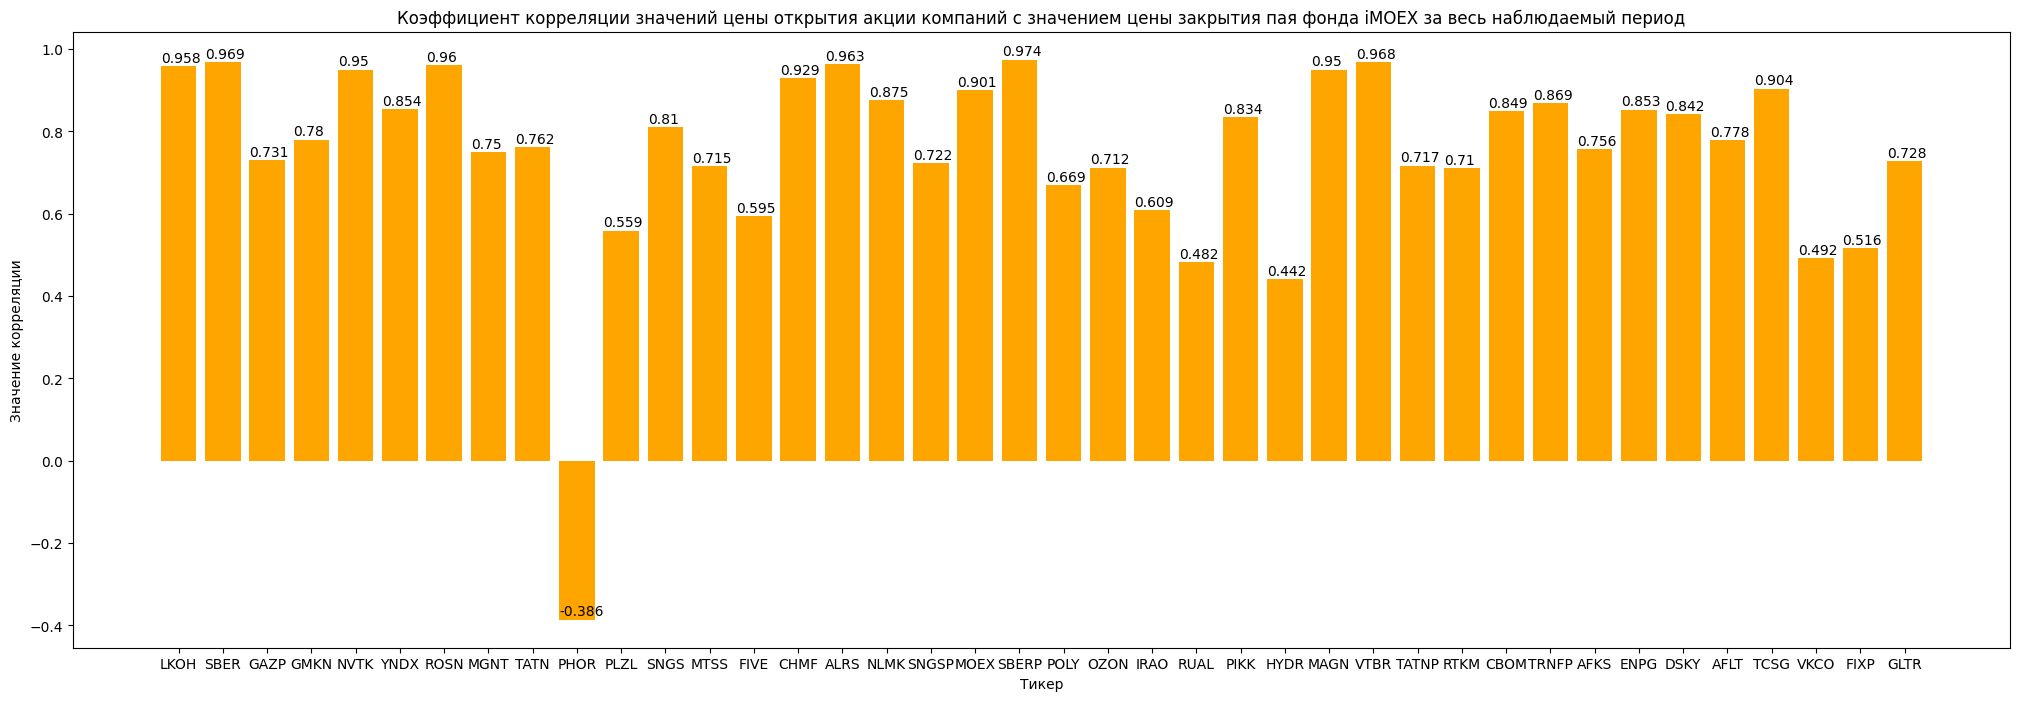

In [10]:
# Tickers open values with y correlation 
open_values_df = corr_df[corr_df['value_1'].str.contains('_open')].reset_index(drop=True)
open_values_df['value_1'] = open_values_df['value_1'].apply(lambda x: x[:-5])

plt.figure(1, figsize=(25,8))
plt.title('Коэффициент корреляции значений цены открытия акции компаний с значением цены закрытия пая фонда iMOEX за весь наблюдаемый период')
plt.bar(open_values_df['value_1'], open_values_df['correlation_value'], color='orange')
plt.xlabel('Тикер')
plt.ylabel('Значение корреляции')

xlocs = [i+1 for i in range(0, len(open_values_df['value_1']))]
for i, v in enumerate(open_values_df['correlation_value'].values):
    plt.text(xlocs[i] - 1.4, v + 0.01, str(v))
    
plt.show()

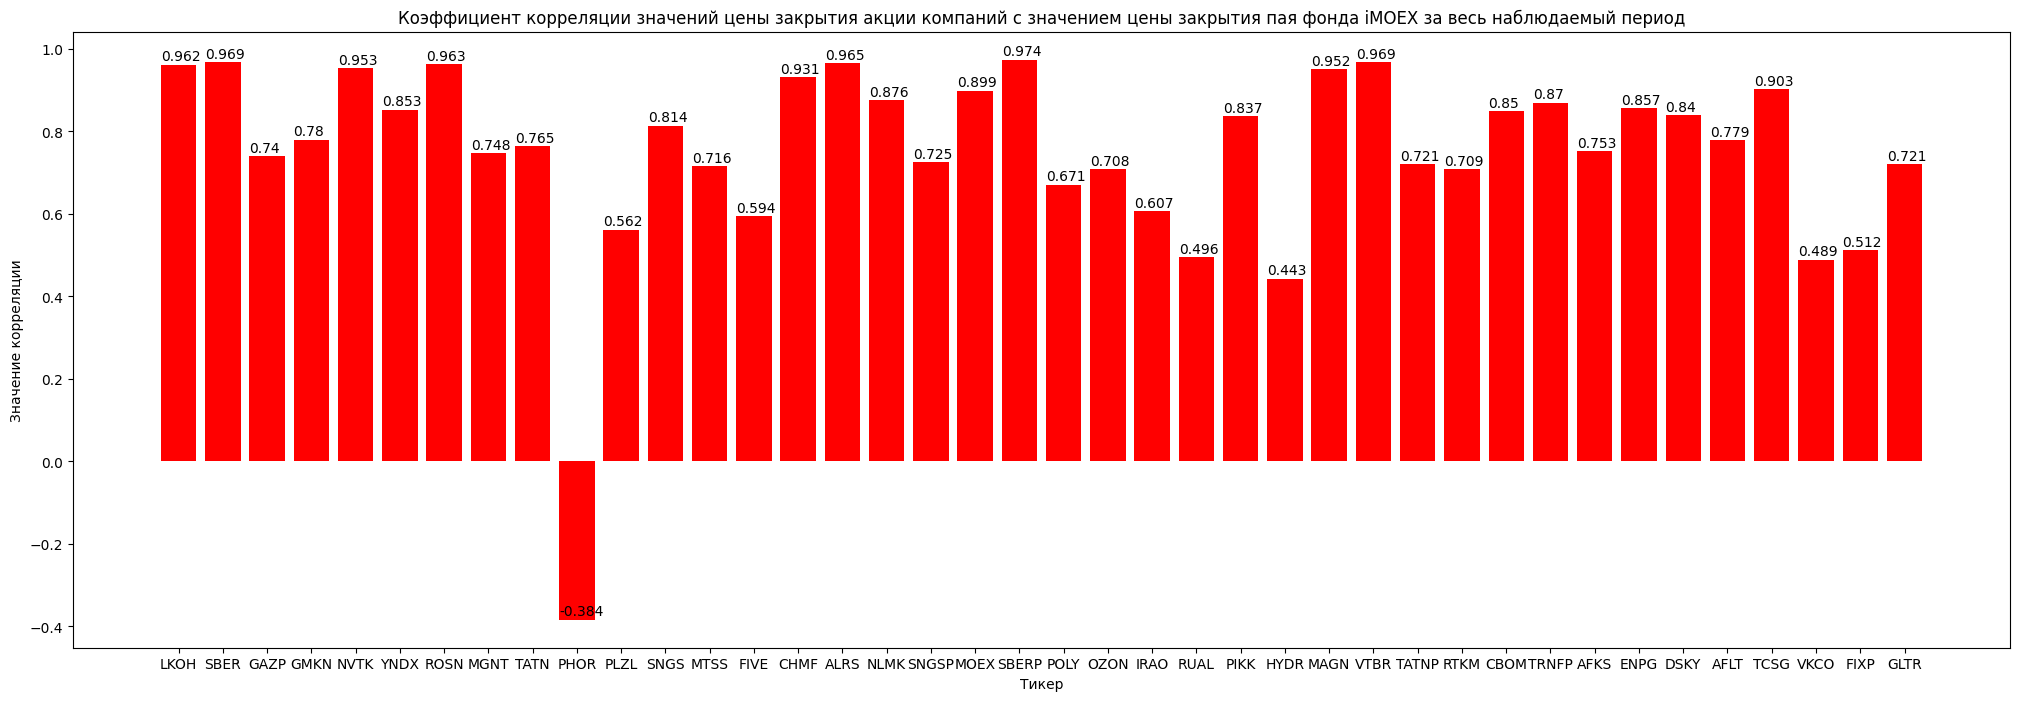

In [11]:
# Tickers close values with y correlation 
close_values_df = corr_df[corr_df['value_1'].str.contains('_close')].reset_index(drop=True)
close_values_df['value_1'] = close_values_df['value_1'].apply(lambda x: x[:-6])

plt.figure(2, figsize=(25,8))
plt.title('Коэффициент корреляции значений цены закрытия акции компаний с значением цены закрытия пая фонда iMOEX за весь наблюдаемый период')
plt.bar(close_values_df['value_1'], close_values_df['correlation_value'], color='red')
plt.xlabel('Тикер')
plt.ylabel('Значение корреляции')

xlocs = [i+1 for i in range(0, len(close_values_df['value_1']))]
for i, v in enumerate(close_values_df['correlation_value'].values):
    plt.text(xlocs[i] - 1.4, v + 0.01, str(v))

plt.show()

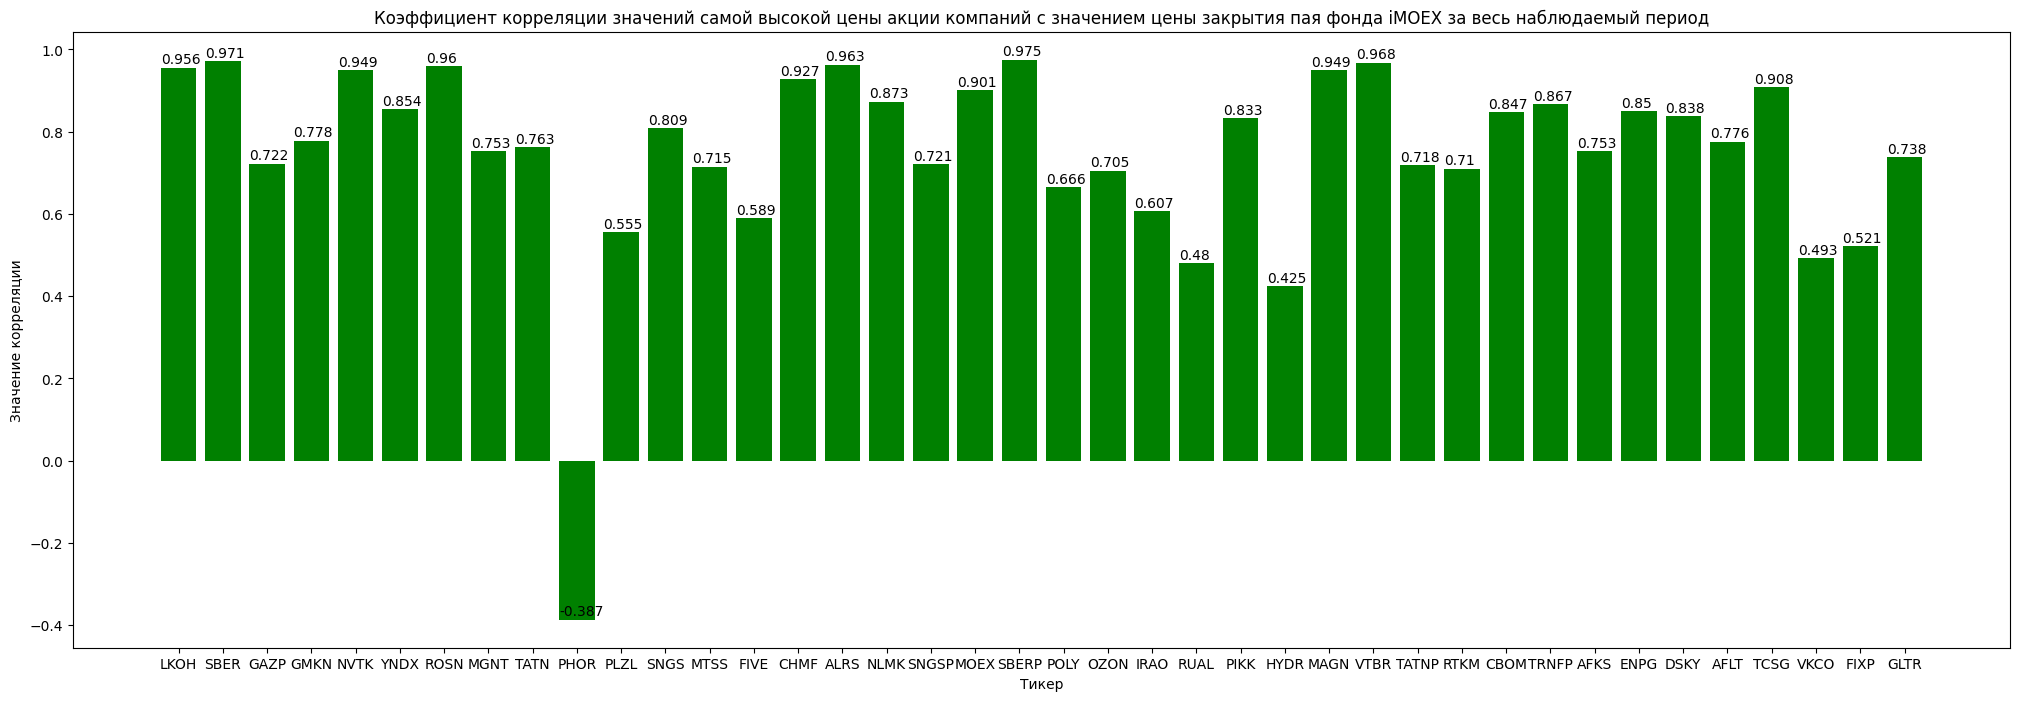

In [12]:
# Tickers high values with y correlation 
high_values_df = corr_df[corr_df['value_1'].str.contains('_high')].reset_index(drop=True)
high_values_df['value_1'] = high_values_df['value_1'].apply(lambda x: x[:-5])

plt.figure(3, figsize=(25,8))
plt.title('Коэффициент корреляции значений самой высокой цены акции компаний с значением цены закрытия пая фонда iMOEX за весь наблюдаемый период')
plt.bar(high_values_df['value_1'], high_values_df['correlation_value'], color='green')
plt.xlabel('Тикер')
plt.ylabel('Значение корреляции')

xlocs = [i+1 for i in range(0, len(high_values_df['value_1']))]
for i, v in enumerate(high_values_df['correlation_value'].values):
    plt.text(xlocs[i] - 1.4, v + 0.01, str(v))

plt.show()

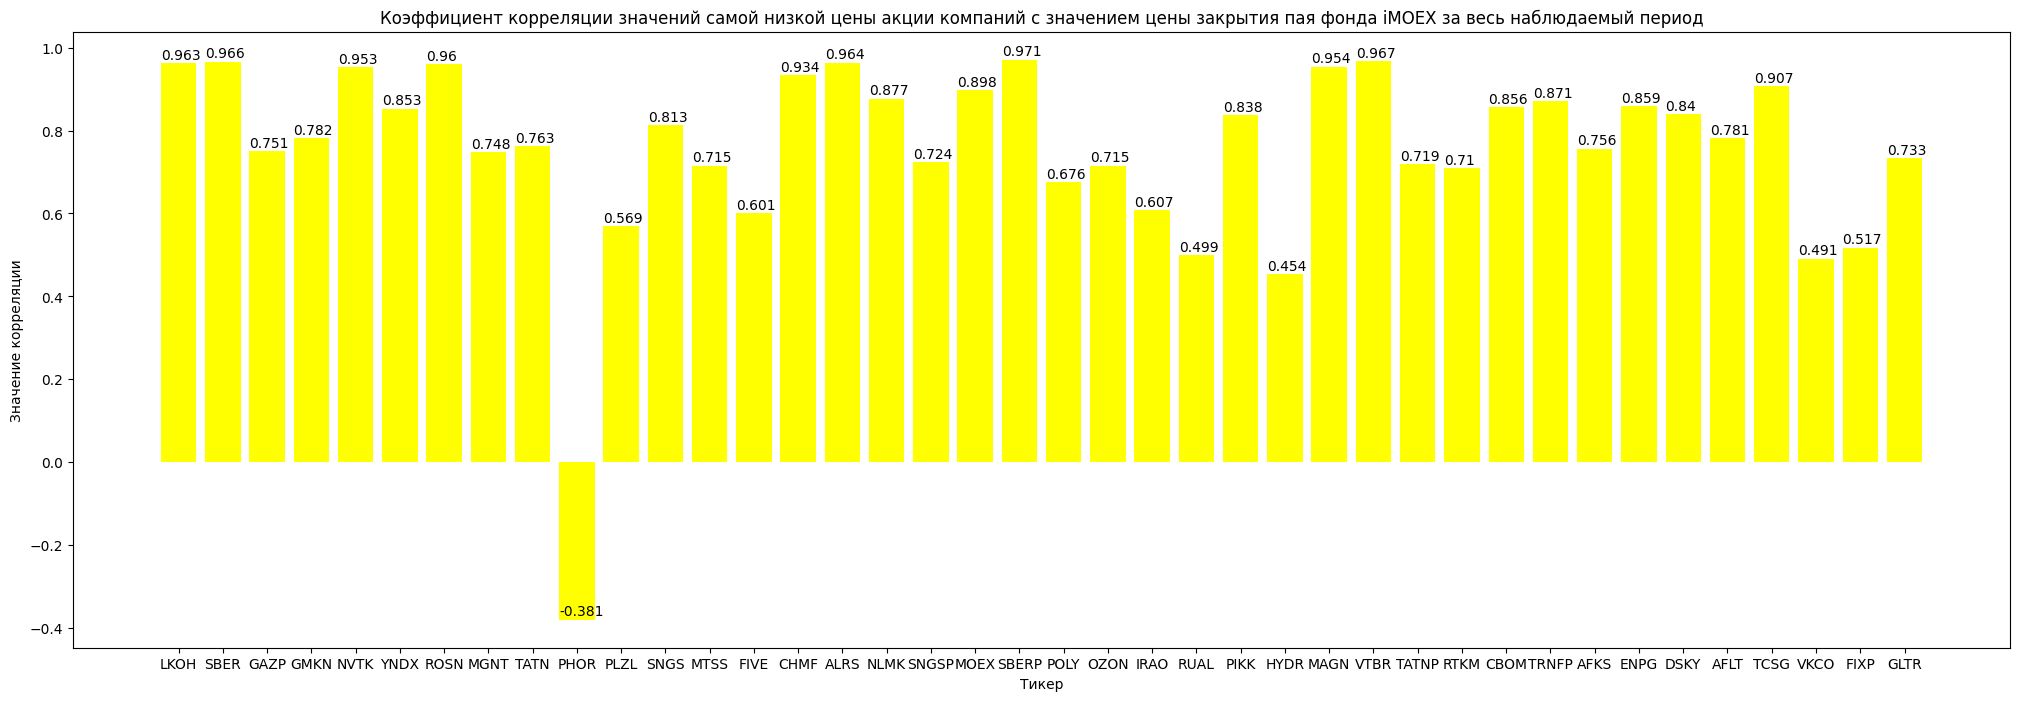

In [13]:
# Tickers low values with y correlation 
low_values_df = corr_df[corr_df['value_1'].str.contains('_low')].reset_index(drop=True)
low_values_df['value_1'] = low_values_df['value_1'].apply(lambda x: x[:-4])

plt.figure(4, figsize=(25,8))
plt.title('Коэффициент корреляции значений самой низкой цены акции компаний с значением цены закрытия пая фонда iMOEX за весь наблюдаемый период')
plt.bar(low_values_df['value_1'], low_values_df['correlation_value'], color='yellow')
plt.xlabel('Тикер')
plt.ylabel('Значение корреляции')

xlocs = [i+1 for i in range(0, len(low_values_df['value_1']))]
for i, v in enumerate(low_values_df['correlation_value'].values):
    plt.text(xlocs[i] - 1.4, v + 0.01, str(v))

plt.show()

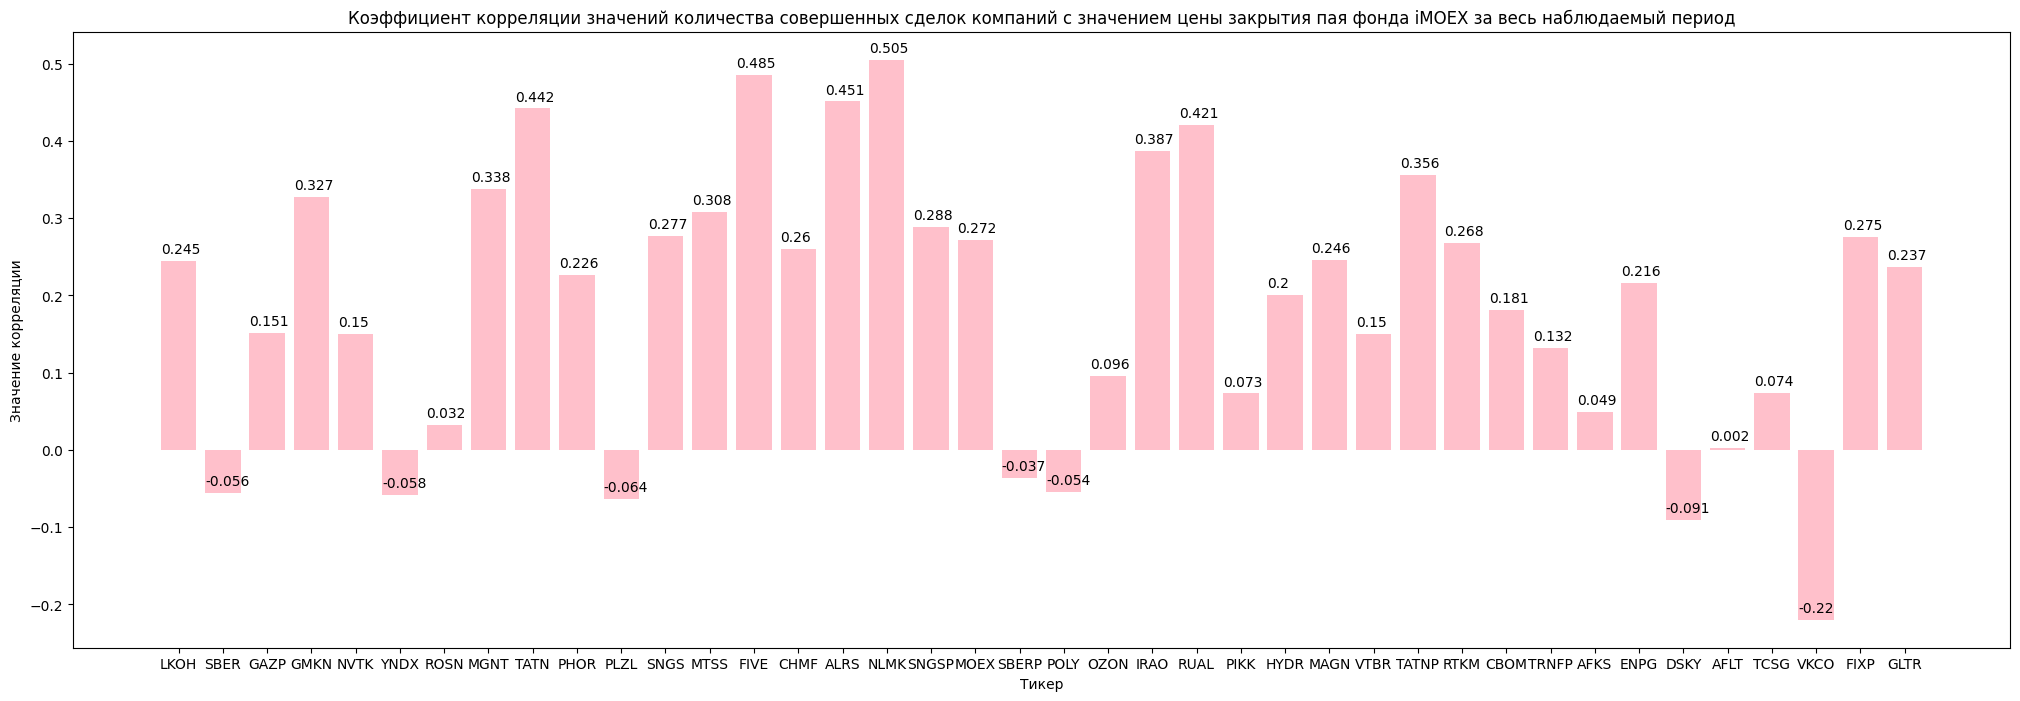

In [14]:
# Tickers volume values with y correlation 
volume_values_df = corr_df[corr_df['value_1'].str.contains('_volume')].reset_index(drop=True)
volume_values_df['value_1'] = volume_values_df['value_1'].apply(lambda x: x[:-7])

plt.figure(5, figsize=(25,8))
plt.title('Коэффициент корреляции значений количества совершенных сделок компаний с значением цены закрытия пая фонда iMOEX за весь наблюдаемый период')
plt.bar(volume_values_df['value_1'], volume_values_df['correlation_value'], color='pink')
plt.xlabel('Тикер')
plt.ylabel('Значение корреляции')

xlocs = [i+1 for i in range(0, len(volume_values_df['value_1']))]
for i, v in enumerate(volume_values_df['correlation_value'].values):
    plt.text(xlocs[i] - 1.4, v + 0.01, str(v))

plt.show()

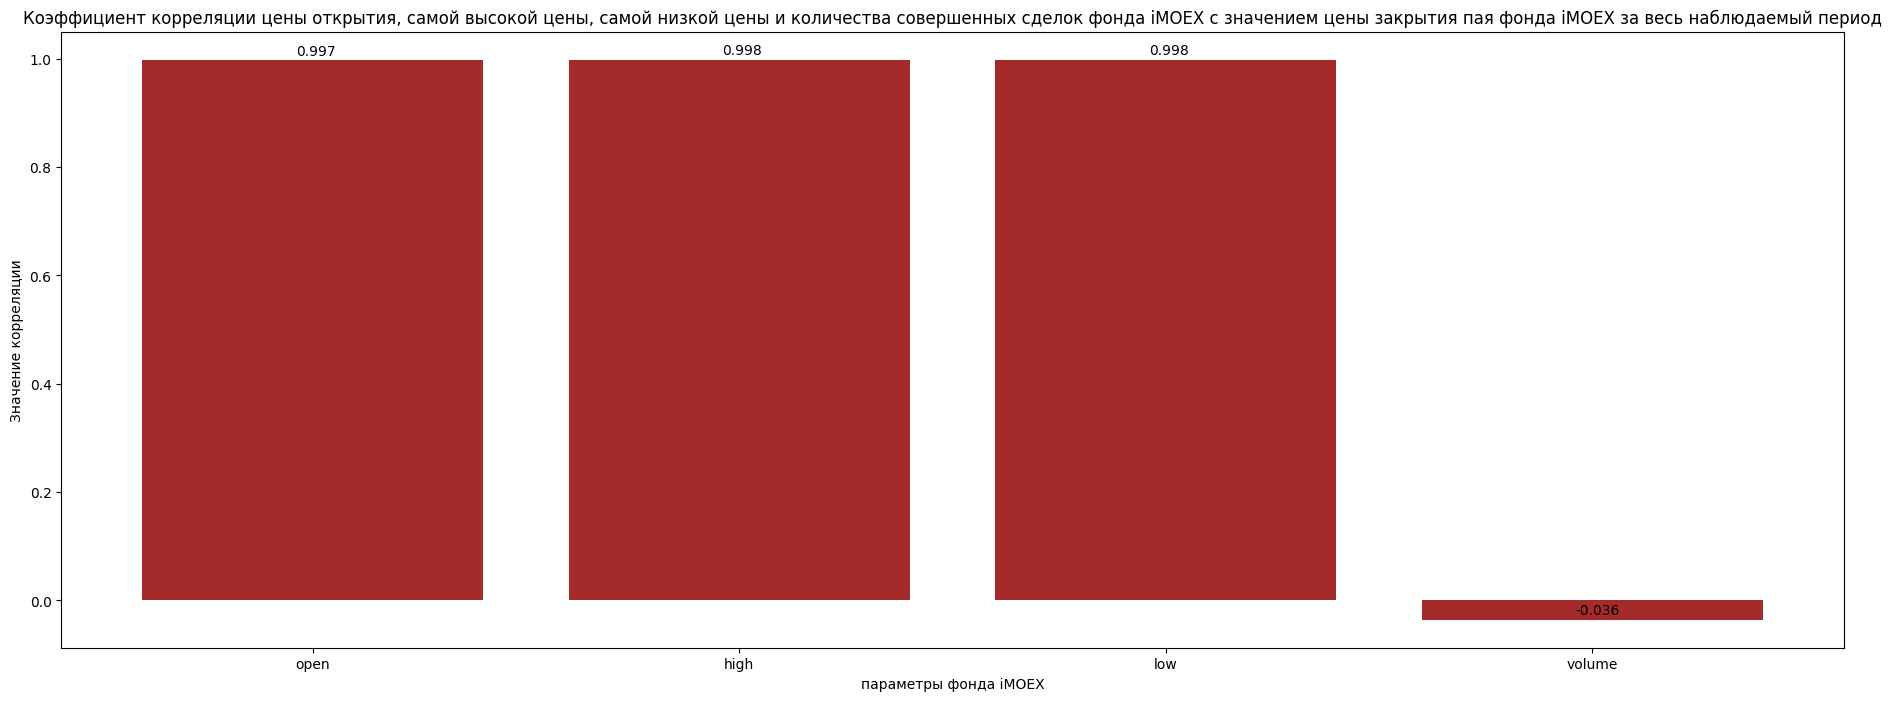

In [15]:
# iMOEX open, high, low, volume values with y (iMOEX close) correlation 
fond_box = []
for column in fond_values.columns:
    val1 = np.array(fond_values[column].values)
    fond_corr_dict = {}
    fond_corr_dict['fond_metric'] = column
    fond_corr_dict['fond_y_value'] = 'iMOEX_close'
    fond_corr_dict['corr_value'] = calculate_correlation(val1, close_values)
    fond_box.append(fond_corr_dict)
fond_corr_df = pd.DataFrame(fond_box)

plt.figure(6, figsize=(23,8))
plt.title('Коэффициент корреляции цены открытия, самой высокой цены, самой низкой цены и количества совершенных сделок фонда iMOEX с значением цены закрытия пая фонда iMOEX за весь наблюдаемый период')
plt.bar(fond_corr_df['fond_metric'], fond_corr_df['corr_value'], color='brown')
plt.xlabel('параметры фонда iMOEX')
plt.ylabel('Значение корреляции')

xlocs = [i+1 for i in range(0, len(fond_corr_df['fond_metric']))]
for i, v in enumerate(fond_corr_df['corr_value'].values):
    plt.text(xlocs[i] - 1.04, v + 0.01, str(v))

plt.show()

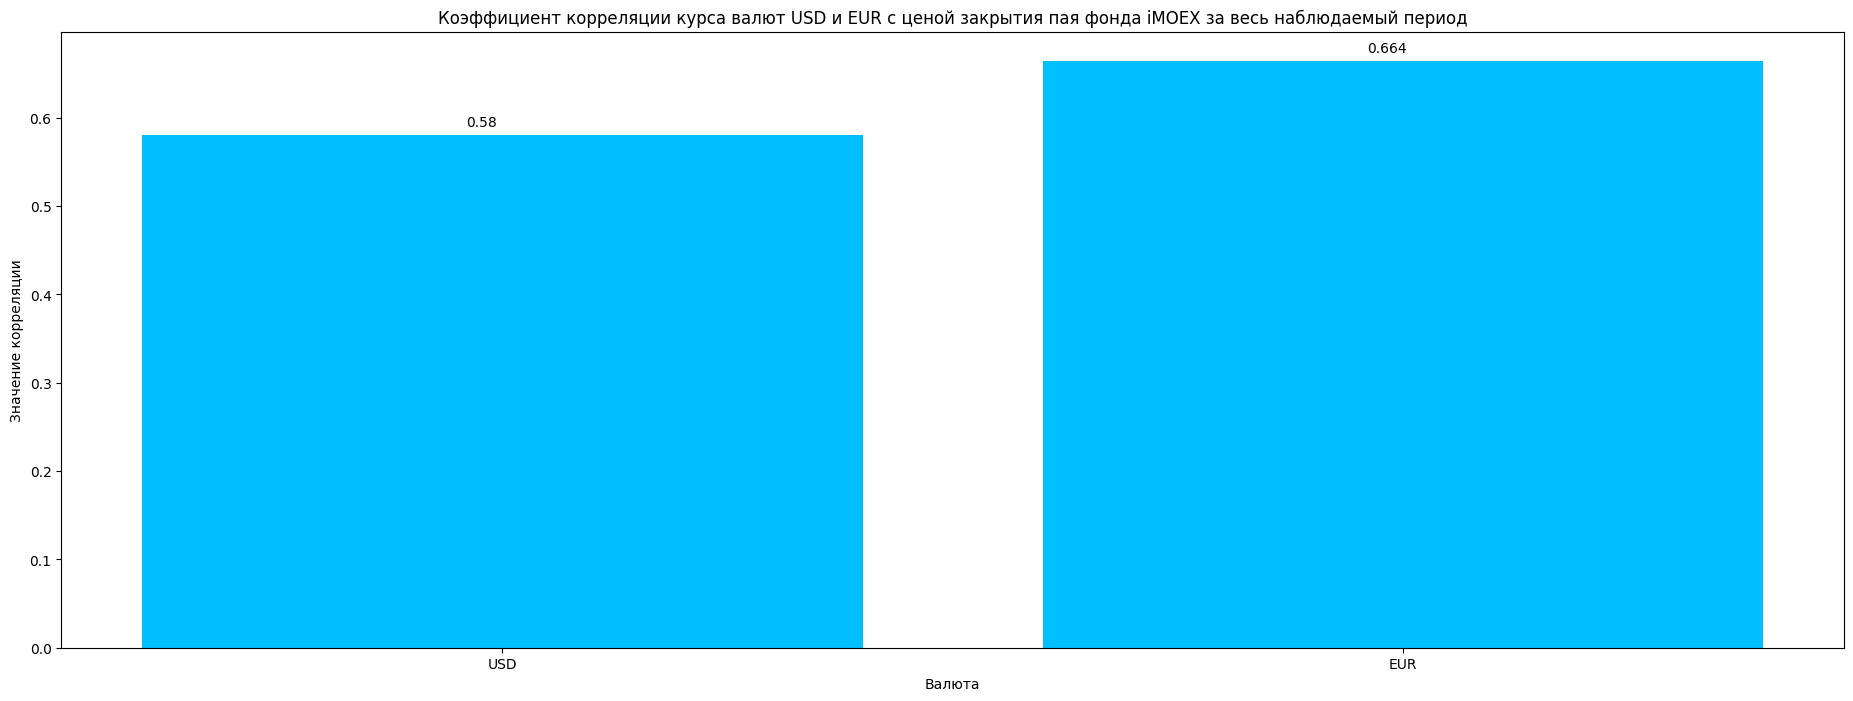

In [16]:
# Exchange rates and close iMOEX correlation
exchange_rates_df.columns=['USD', 'EUR']
exchange_rates_corr = []
for column in exchange_rates_df.columns:
    val1 = np.array(exchange_rates_df[column].values)
    exchange_corr_dict = {}
    exchange_corr_dict['exchange_rate_curr'] = column
    exchange_corr_dict['y_value'] = 'iMOEX_close'
    exchange_corr_dict['corr_value'] = calculate_correlation(val1, close_values)
    exchange_rates_corr.append(exchange_corr_dict)
    
exchange_rates_corr_df = pd.DataFrame(exchange_rates_corr)

plt.figure(7, figsize=(23,8))
plt.title('Коэффициент корреляции курса валют USD и EUR c ценой закрытия пая фонда iMOEX за весь наблюдаемый период')
plt.bar(exchange_rates_corr_df['exchange_rate_curr'], exchange_rates_corr_df['corr_value'], color='deepskyblue')
plt.xlabel('Валюта')
plt.ylabel('Значение корреляции')

xlocs = [i+1 for i in range(0, len(exchange_rates_corr_df['exchange_rate_curr']))]
for i, v in enumerate(exchange_rates_corr_df['corr_value'].values):
    plt.text(xlocs[i] - 1.04, v + 0.01, str(v))

plt.show()

## Корректируем текущий датасет и формируем train/test таблицы


In [17]:
dataset = pd.concat([dataset, fond_values], axis=1)

# Убираем столбцы коэффициент корреляции которых меньше 0.5
invalid_open_columns = open_values_df[open_values_df['correlation_value'] <= 0.5]['value_1'].apply(lambda x: x + '_open').values
invalid_close_columns = close_values_df[close_values_df['correlation_value'] <= 0.5]['value_1'].apply(lambda x: x + '_close').values
invalid_high_columns = high_values_df[high_values_df['correlation_value'] <= 0.5]['value_1'].apply(lambda x: x + '_high').values
invalid_low_columns = low_values_df[low_values_df['correlation_value'] <= 0.5]['value_1'].apply(lambda x: x + '_low').values
invalid_volume_columns = volume_values_df[volume_values_df['correlation_value'] <= 0.5]['value_1'].apply(lambda x: x + '_volume').values

columns_blocks = [invalid_open_columns, invalid_close_columns, invalid_high_columns, invalid_low_columns, invalid_volume_columns] 

for pack in columns_blocks:
    dataset.drop(columns=pack, inplace=True)
    
dataset.drop(columns=['volume'], inplace=True)

In [18]:
data = dataset.copy()
data = pd.concat([data, exchange_rates_df], axis=1)
data['close'] = close_values
data['y'] = data['close'].shift(-1)

test_view = data.iloc[:, -2:]
test_view['date'] = dates

data = data.iloc[:-1, :]
data.drop(columns=['close'], inplace=True)

In [26]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

X_train = data.iloc[:-10, :-1]
#X_train = pd.DataFrame(scalar.fit_transform(X_train), index=X_train.index, columns=X_train.columns).round(3)

X_test = data.iloc[-10:, :-1]
#X_test = pd.DataFrame(scalar.fit_transform(X_test), index=X_test.index, columns=X_test.columns).round(3)

y_train = data.iloc[:-10, -1:]
y_test = data.iloc[-10:, -1:]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (538, 150)
y_train shape: (538, 1)
X_test shape: (10, 150)
y_test shape: (10, 1)


## Линейная регрессия

In [27]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_train.values.tolist(), y_train.values.tolist())

LinearRegression()

In [28]:
linear_model.score(X_test.values.tolist(), y_test.values.tolist())

-4.735140622145425

In [29]:
y_pred = linear_model.predict(X_test.values)

In [30]:
tests = test_view.copy()
tests = tests.iloc[-11:-1, :]
tests['pred'] = y_pred
tests = tests[['date', 'y', 'pred']]
tests['pred'] = tests['pred'].round(3)

In [31]:
tests['y_minus_pred'] = tests['y'] - tests['pred']
tests['squared'] = tests['y_minus_pred'] ** 2
tests['abs'] = tests['y_minus_pred'].apply(lambda x: abs(x))

In [32]:
tests

,date,y,pred,y_minus_pred,squared,abs
538,2022-11-11,4.142,4.143,-0.001,1.000000e-06,0.001
539,2022-11-14,4.040,4.166,-0.126,1.587600e-02,0.126
540,2022-11-15,4.116,4.006,0.110,1.210000e-02,0.110
541,2022-11-16,4.114,4.095,0.019,3.610000e-04,0.019
542,2022-11-17,4.086,4.100,-0.014,1.960000e-04,0.014
543,2022-11-18,4.060,4.151,-0.091,8.281000e-03,0.091
544,2022-11-21,4.068,4.072,-0.004,1.600000e-05,0.004
545,2022-11-22,4.094,4.113,-0.019,3.610000e-04,0.019
546,2022-11-23,4.100,4.154,-0.054,2.916000e-03,0.054
547,2022-11-24,4.074,4.159,-0.085,7.225000e-03,0.085


## Расчет метрик

In [33]:
rmse = round((tests['squared'].sum() / tests['squared'].size) ** 0.5, 3)
mae = round(tests['abs'].sum() / tests['abs'].size, 3)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.069
MAE: 0.052


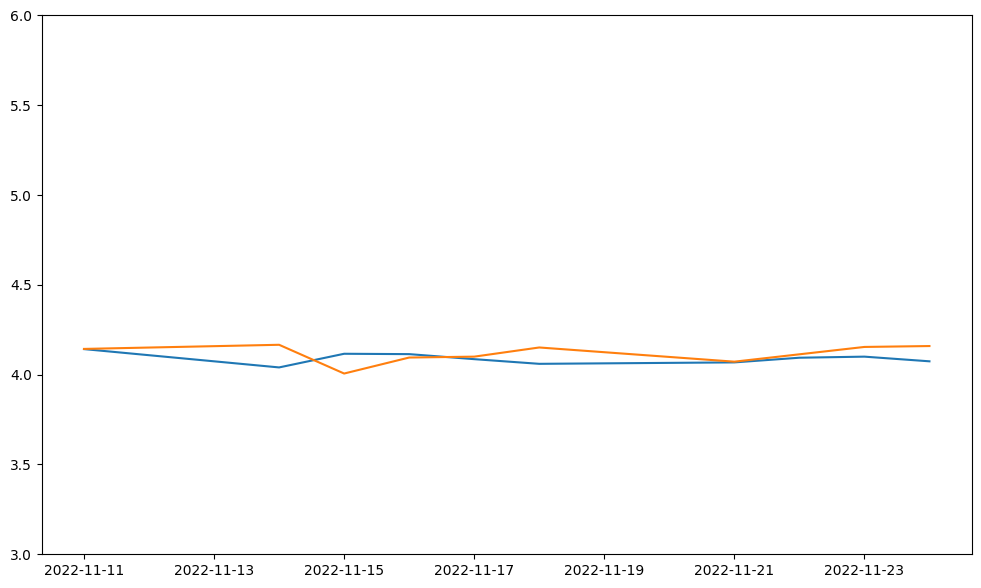

In [35]:
plt.figure(8, figsize=(12,7))
plt.plot(tests['date'], tests['y'], label='actual')
plt.plot(tests['date'], tests['pred'], label='predicted')
plt.ylim(3,6)
plt.show()